In [31]:
 import utils

# Get the default financial and AC Model parameters
financial_params, ac_params = utils.get_env_param()

In [2]:
financial_params

Annual Volatility:,12%,Bid-Ask Spread:,0.125
Daily Volatility:,0.8%,Daily Trading Volume:,"5,000,000"


In [3]:
ac_params

Total Number of Shares to Sell:,"1,000,000",Fixed Cost of Selling per Share:,$0.062
Starting Price per Share:,$50.00,Trader's Risk Aversion:,1e-06
Price Impact for Each 1% of Daily Volume Traded:,$2.5e-06,Permanent Impact Constant:,2.5e-07
Number of Days to Sell All the Shares:,60,Single Step Variance:,0.144
Number of Trades:,60,Time Interval between trades:,1.0


In [40]:
import numpy as np

import importlib
import syntheticChrissAlmgren as sca
importlib.reload(sca)

from ddpg_agent import Agent

from collections import deque

def test_agent(use_custom_reward, sparse_reward):
    env = sca.MarketEnvironment()
    agent = Agent(state_size=env.observation_space_dimension(), action_size=env.action_space_dimension(), random_seed=0)
    lqt = 60
    n_trades = 60
    tr = 1e-6
    episodes = 1000
    shortfall_hist = np.array([])
    shortfall_deque = deque(maxlen=100)

    for episode in range(episodes):
        cur_state = env.reset(seed=episode, liquid_time=lqt, num_trades=n_trades, lamb=tr, use_custom_reward=use_custom_reward, sparse_reward=sparse_reward)


        env.start_transactions()

        for i in range(n_trades + 1):

            action = agent.act(cur_state, add_noise = True)

            new_state, reward, done, info = env.step(action)

            agent.step(cur_state, action, reward, new_state, done)

            cur_state = new_state

            if info.done:
                shortfall_hist = np.append(shortfall_hist, info.implementation_shortfall)
                shortfall_deque.append(info.implementation_shortfall)
                break


    print(f'\nAverage Implementation Shortfall for sparse_reward={sparse_reward}: ${np.mean(shortfall_hist):,.2f} \n')



test_agent(use_custom_reward=True, sparse_reward=False)

test_agent(use_custom_reward=True, sparse_reward=True)


Average Implementation Shortfall for sparse_reward=False: $2,483,291.85 


Average Implementation Shortfall for sparse_reward=True: $2,534,694.12 



# Todo

The above code should provide you with a starting framework for incorporating more complex dynamics into our model. Here are a few things you can try out:

- Explain why log-returns in a time window of 6 periods, along with $m_k$ and $i_k$ is a good choice for the state? Could you expand or shrink $D$ = number of past log-returns (which is considered $D=5$) to get better results?

- Incorporate your own reward function in the simulation environmet to see if you can achieve a expected shortfall that is better (lower) than that produced by the Almgren and Chriss model.


- Experiment rewarding the agent at every step and only giving a reward at the end. Which is; what happens if the reward function is sparse?


- Use more realistic price dynamics, such as geometric brownian motion (GBM). The equations used to model GBM can be found in section 3b of paper: GBM


- Try different functions for the action. You can change the values of the actions produced by the agent by using different functions. You can choose your function depending on the interpretation you give to the action. For example, you could set the action to be a **function of the trading rate**.


- Add more complex dynamics to the environment. Try incorporate trading fees, for example. This can be done by adding and extra term to the fixed cost of selling, $\epsilon$.

- Use SAC (soft actor-critic) and TD3 (Twin Delayed Deep Deterministic) with different hyperparameters and network structures to compare your results to DDPG results. Explain why this happens.

In [41]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
import syntheticChrissAlmgren as sca


class ACEnv(gym.Env):
    metadata = {'render.modes': []}

    def __init__(self):
        super().__init__()
        # using market env for simulation with a gym wrapper
        self.env = sca.MarketEnvironment()
        dim_obs = self.env.observation_space_dimension()
        dim_act = self.env.action_space_dimension()
        self.observation_space = gym.spaces.Box(-np.inf, np.inf, (dim_obs,), dtype=np.float32)
        self.action_space = gym.spaces.Box(0.0, 1.0, (dim_act,), dtype=np.float32)

    def seed(self, seed=None): return [seed]

    def reset(self, **kwargs):
        obs = self.env.reset(
            seed=kwargs.get('seed', None),
            liquid_time=60,
            num_trades=60,
            lamb=1e-6,
            use_custom_reward=True,
            sparse_reward=True
        )
        return obs.astype(np.float32)

    # def step(self, action):
    #     obs, reward, done, info_obj = self.env.step(action)
    #     info = {'implementation_shortfall': getattr(info_obj, 'implementation_shortfall', None)}
    #     return obs.astype(np.float32), float(reward), done, info

    def step(self, action):
        obs, reward, done, info_obj = self.env.step(action)

        sold = getattr(info_obj, 'share_to_sell_now', 0)
        rem  = getattr(self.env, 'shares_remaining', 0)
        sf   = getattr(info_obj, 'implementation_shortfall', None)

        info = {
            'share_to_sell_now':        sold,
            'shares_remaining':         rem,
            'implementation_shortfall': sf
        }
        return obs.astype(np.float32), float(reward), done, info
    def render(self, mode='human'): pass


Training SAC:   0%|          | 0/20000 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_46888\2595053013.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return obs.astype(np.float32), float(reward), done, info
Training SAC: 100%|██████████| 20000/20000 [01:28<00:00, 227.22it/s]


Episode 1: shortfall = $1,204,323.42
Episode 2: shortfall = $666,510.90
Episode 3: shortfall = $859,003.68
Episode 4: shortfall = $1,128,130.40
Episode 5: shortfall = $1,204,340.96
Episode 6: shortfall = $820,826.61
Episode 7: shortfall = $989,856.16
Episode 8: shortfall = $1,047,839.86
Episode 9: shortfall = $1,189,500.35
Episode 10: shortfall = $732,908.07
Episode 11: shortfall = $1,194,985.39
Episode 12: shortfall = $1,017,748.48
Episode 13: shortfall = $1,269,276.72
Episode 14: shortfall = $1,157,237.16
Episode 15: shortfall = $1,018,378.91
Episode 16: shortfall = $1,425,520.36
Episode 17: shortfall = $884,224.08
Episode 18: shortfall = $1,296,366.09
Episode 19: shortfall = $1,132,925.23
Episode 20: shortfall = $847,999.20
Episode 21: shortfall = $899,655.06
Episode 22: shortfall = $767,630.48
Episode 23: shortfall = $958,319.93
Episode 24: shortfall = $1,281,795.73
Episode 25: shortfall = $1,007,488.14
Episode 26: shortfall = $1,278,001.17
Episode 27: shortfall = $1,335,894.33
Epi

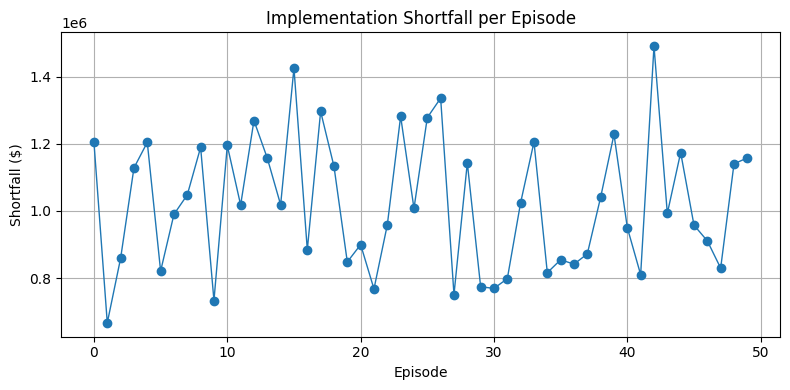

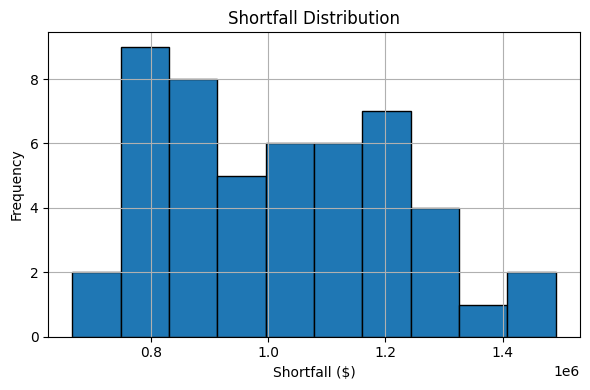


Statistics:
 • Mean:    $1,022,993.55
 • Median:  $1,012,618.31
 • StdDev:  $197,707.62
 • 25th %:  $849,666.50
 • 75th %:  $1,185,590.74
Step | Shares Sold
------------------
   0 | 496565
   1 | 250738
   2 | 126242
   3 |  63264
   4 |  31629
   5 |  15805
   6 |   7896
   7 |   3941
   8 |   1965
   9 |    980
  10 |    489
  11 |    243
  12 |    122
  13 |     61
  14 |     30
  15 |     15
  16 |      8
  17 |      4
  18 |      2
  19 |      1


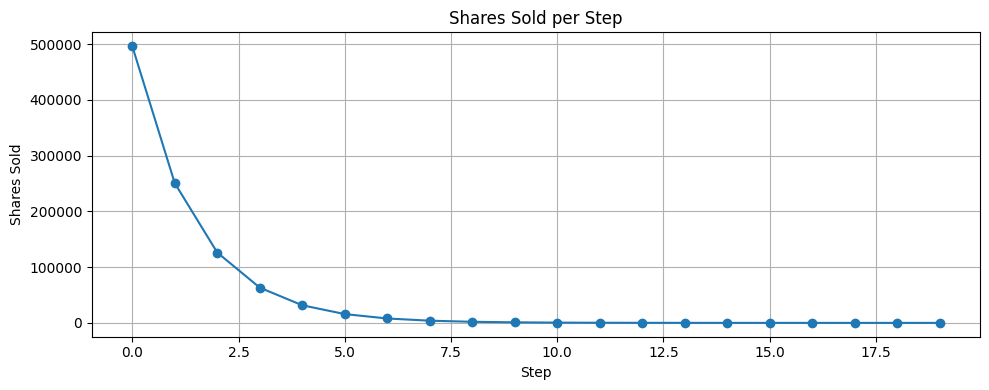

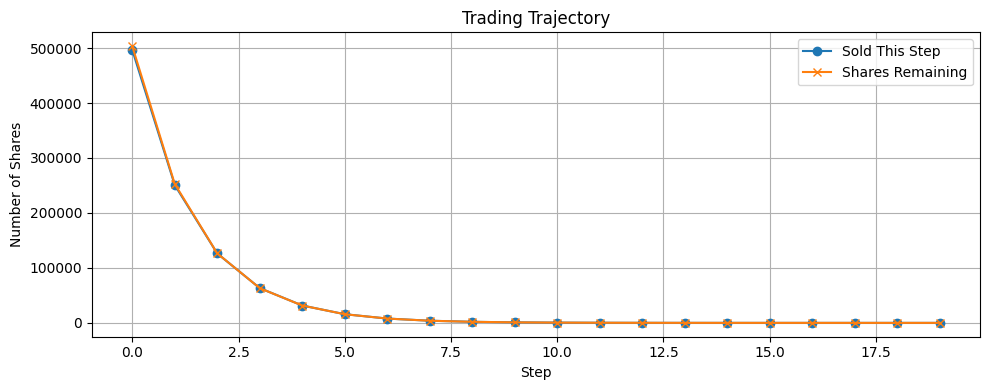

In [42]:

train_env = make_vec_env(ACEnv, n_envs=1)

model = SAC(
    "MlpPolicy",
    train_env,
    learning_rate=3e-4,
    batch_size=64,
    tau=0.01,
    policy_kwargs=dict(net_arch=[64, 64]),
    verbose=0,
    device="cpu"
)

total_timesteps = 20_000
pbar = trange(total_timesteps, desc="Training SAC", leave=True)
t = 0
while t < total_timesteps:
    chunk = min(1000, total_timesteps - t)
    model.learn(total_timesteps=chunk, reset_num_timesteps=False, progress_bar=False)
    t += chunk
    pbar.update(chunk)
pbar.close()

eval_env = ACEnv()
n_eval_episodes = 50
shortfalls = []

for ep in range(1, n_eval_episodes + 1):
    obs = eval_env.reset()
    eval_env.env.start_transactions()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, done, info = eval_env.step(action)
    sf = info['implementation_shortfall']
    shortfalls.append(sf)
    print(f"Episode {ep}: shortfall = ${sf:,.2f}")


plt.figure(figsize=(8, 4))
plt.plot(shortfalls, marker='o', lw=1)
plt.title("Implementation Shortfall per Episode")
plt.xlabel("Episode")
plt.ylabel("Shortfall ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 4))
plt.hist(shortfalls, bins=10, edgecolor='k')
plt.title("Shortfall Distribution")
plt.xlabel("Shortfall ($)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


mean_sf = np.mean(shortfalls)
median_sf = np.median(shortfalls)
std_sf = np.std(shortfalls)
p25, p75 = np.percentile(shortfalls, [25, 75])
print("\nStatistics:")
print(f" • Mean:    ${mean_sf:,.2f}")
print(f" • Median:  ${median_sf:,.2f}")
print(f" • StdDev:  ${std_sf:,.2f}")
print(f" • 25th %:  ${p25:,.2f}")
print(f" • 75th %:  ${p75:,.2f}")

eval_env = ACEnv()
obs = eval_env.reset()
eval_env.env.start_transactions()

shares_sold = []
shares_remaining = []
t = 0

print("Step | Shares Sold")
print("------------------")
done = False
while not done:
    action, _ = model.predict(obs, deterministic=True)
    frac = action.item()

    state, reward, done, info_obj = eval_env.env.step(action)

    sold = info_obj.share_to_sell_now
    rem = eval_env.env.shares_remaining

    shares_sold.append(sold)
    shares_remaining.append(rem)

    print(f"{t:4d} | {int(sold):6d}")

    obs = state
    t += 1


import matplotlib.pyplot as plt

steps = list(range(len(shares_sold)))

plt.figure(figsize=(10, 4))
plt.plot(steps, shares_sold, marker='o', linestyle='-')
plt.title("Shares Sold per Step")
plt.xlabel("Step")
plt.ylabel("Shares Sold")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(steps, shares_sold, marker='o', label='Sold This Step')
plt.plot(steps, shares_remaining, marker='x', label='Shares Remaining')
plt.title("Trading Trajectory")
plt.xlabel("Step")
plt.ylabel("Number of Shares")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Training TD3:   0%|          | 0/20000 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_46888\2595053013.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return obs.astype(np.float32), float(reward), done, info
Training TD3: 100%|██████████| 20000/20000 [00:49<00:00, 403.87it/s]


Episode | Shortfall
---------------------
      1 | $360,614.65
      2 | $330,621.45
      3 | $-734,119.71
      4 | $379,404.27
      5 | $551,194.78
      6 | $838,736.24
      7 | $318,462.86
      8 | $-680,877.54
      9 | $-171,286.14
     10 | $-116,618.28
     11 | $-733,056.54
     12 | $517,916.08
     13 | $-509,492.46
     14 | $303,673.43
     15 | $304,761.68
     16 | $1,620,831.15
     17 | $976,141.09
     18 | $703,889.19
     19 | $1,176,221.97
     20 | $-636,809.28
     21 | $668,803.47
     22 | $293,377.30
     23 | $41,928.06
     24 | $688,326.55
     25 | $149,479.14
     26 | $1,326,188.19
     27 | $-479,887.56
     28 | $-11,337.56
     29 | $670,302.04
     30 | $1,412,438.83
     31 | $96,004.14
     32 | $1,371,165.13
     33 | $-565,532.35
     34 | $-212,235.41
     35 | $380,837.77
     36 | $595,436.97
     37 | $-17,908.71
     38 | $366,203.24
     39 | $980,541.86
     40 | $-117,522.01
     41 | $776,806.76
     42 | $932,714.40
     43 | $636,

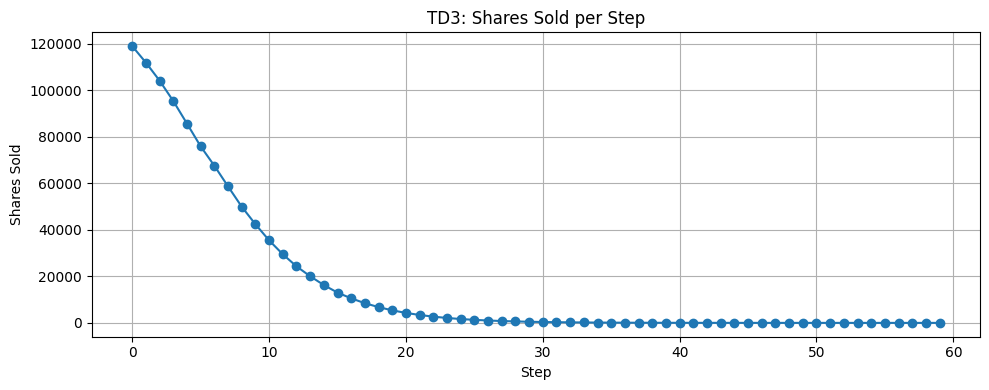

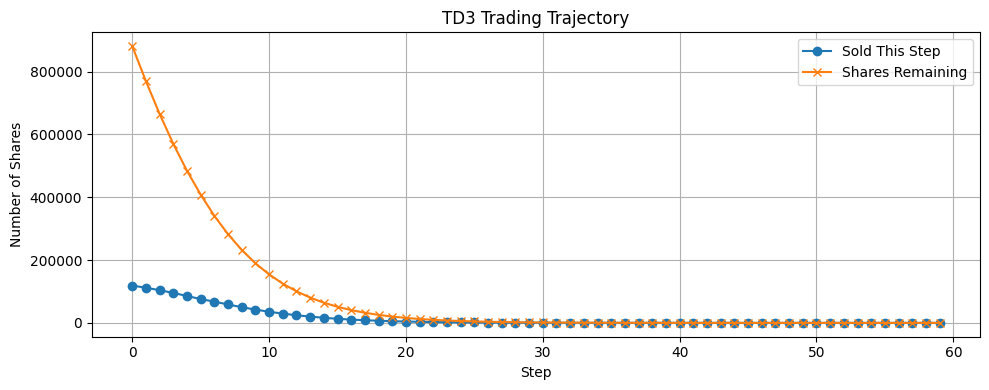

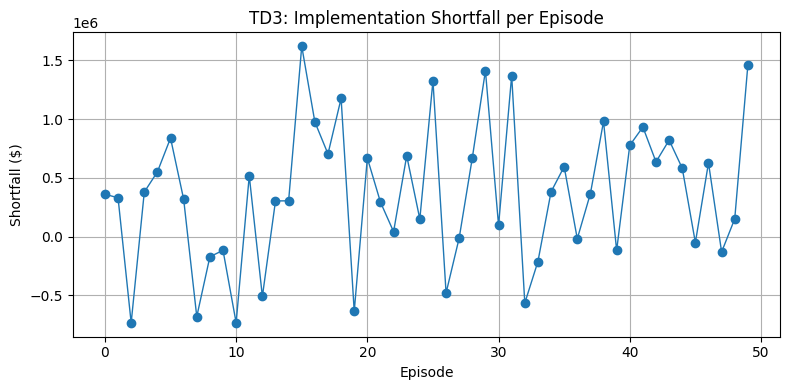

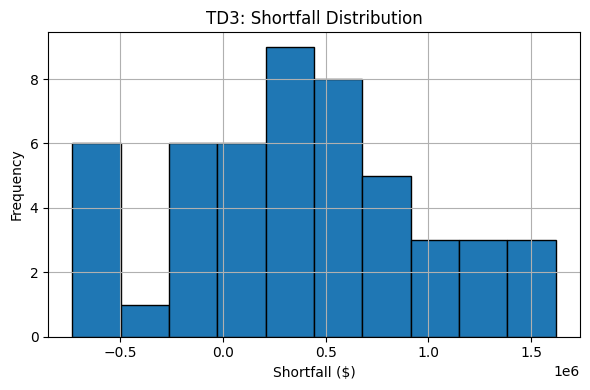


TD3 Statistics:
 • Mean:    $364,847.18
 • Median:  $363,408.95
 • StdDev:  $596,341.44
 • 25th %:  $-42,630.06
 • 75th %:  $699,998.53


In [43]:

import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from stable_baselines3 import TD3
from stable_baselines3.common.vec_env import DummyVecEnv
import syntheticChrissAlmgren as sca



train_env = DummyVecEnv([lambda: ACEnv()])

model = TD3(
    "MlpPolicy",
    train_env,
    learning_rate=3e-4,
    batch_size=64,
    tau=0.01,
    policy_kwargs=dict(net_arch=[64, 64]),
    verbose=0,
    device="cpu"
)

total_timesteps = 20_000
pbar = trange(total_timesteps, desc="Training TD3", leave=True)
timesteps = 0
while timesteps < total_timesteps:
    chunk = min(1000, total_timesteps - timesteps)
    model.learn(total_timesteps=chunk, reset_num_timesteps=False, progress_bar=False)
    timesteps += chunk
    pbar.update(chunk)
pbar.close()

# 4) Evaluate over multiple episodes, print shortfall per episode
eval_env = ACEnv()
n_eval = 50
shortfalls = []

print("Episode | Shortfall")
print("---------------------")
for ep in range(1, n_eval + 1):
    obs = eval_env.reset()
    eval_env.env.start_transactions()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, done, info = eval_env.step(action)
    sf = info['implementation_shortfall']
    shortfalls.append(sf)
    print(f"{ep:7d} | ${sf:,.2f}")

# 5) Run one episode to record per-step shares sold and remaining
obs = eval_env.reset()
eval_env.env.start_transactions()
shares_sold = []
shares_rem = []
step = 0
print("\nStep | Shares Sold | Shares Remaining")
print("-------------------------------------")
done = False
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, _, done, info = eval_env.step(action)
    sold = info['share_to_sell_now']
    rem = info['shares_remaining']
    shares_sold.append(sold)
    shares_rem.append(rem)
    print(f"{step:4d} | {int(sold):11d} | {int(rem):16d}")
    step += 1

# 6) Plot shares sold per step and trajectory
steps = list(range(len(shares_sold)))

plt.figure(figsize=(10, 4))
plt.plot(steps, shares_sold, marker='o')
plt.title("TD3: Shares Sold per Step")
plt.xlabel("Step")
plt.ylabel("Shares Sold")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(steps, shares_sold, marker='o', label='Sold This Step')
plt.plot(steps, shares_rem, marker='x', label='Shares Remaining')
plt.title("TD3 Trading Trajectory")
plt.xlabel("Step")
plt.ylabel("Number of Shares")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(shortfalls, marker='o', lw=1)
plt.title("TD3: Implementation Shortfall per Episode")
plt.xlabel("Episode")
plt.ylabel("Shortfall ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(shortfalls, bins=10, edgecolor='k')
plt.title("TD3: Shortfall Distribution")
plt.xlabel("Shortfall ($)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

mean_sf = np.mean(shortfalls)
median_sf = np.median(shortfalls)
std_sf = np.std(shortfalls)
p25, p75 = np.percentile(shortfalls, [25, 75])

print("\nTD3 Statistics:")
print(f" • Mean:    ${mean_sf:,.2f}")
print(f" • Median:  ${median_sf:,.2f}")
print(f" • StdDev:  ${std_sf:,.2f}")
print(f" • 25th %:  ${p25:,.2f}")
print(f" • 75th %:  ${p75:,.2f}")


observation : both SAC and TD3 are selling as much share as possible in the first sessions this could be problemetic since there is no implementation of fee also the market execution is considered to be immediate

In [ ]:
i cant make sense of why that negative shortfall appears
